## Upload Triples to Qdrant Vector DB

In [89]:
# data preprocessing 
import json

with open('data.json', 'r') as f:
    contents = json.load(f)

In [90]:
with open('strategyqa-data/strategyqa_dataset/strategyqa_train_paragraphs.json', 'r') as f:
    paragraph_content = json.load(f)

In [91]:
count = 0
def get_paragraph_citation(paragraph):
    for p in paragraph_content:
        if(paragraph_content[p]['content'] == paragraph):
            return p
    count += 1 

In [92]:
count = 0
# get all paragraph citations
for content in contents:
    contents[count]['paragraph-citation'] = get_paragraph_citation(content['paragraph'])
    count += 1

In [114]:
# Structure:
# triple_point: _
# type: subject1, predicate, subject2
# triple: (_, _, _) this is the part of the triple it's referring to
# paragraph: reference to paragraph
subject_payloads = []
predicate_payloads = []
values = []
for c in contents:
    # triples for a given paragraph
    triples = c['response']['choices'][0]['text'].strip().split("\n")
    for triple in triples:
        trip_split = [val[1:-1] for val in triple.strip()[1:-1].split(", ")]
        if len(trip_split) == 3:
            # subject 1
            payload = {}
            payload["triple_point"] = trip_split[0]
            payload["type"] = "subject1"
            payload["predicate"] = trip_split[1]
            payload["triple"] = triple.strip()
            payload["paragraph_citation"] = c['paragraph-citation']
            subject_payloads.append(payload)
            # predicate
            payload = {}
            payload["triple_point"] = trip_split[1]
            payload["type"] = "predicate"
            payload["triple"] = triple.strip()
            payload["paragraph_citation"] = c['paragraph-citation']
            predicate_payloads.append(payload)
            # subject 2
            payload = {}
            payload["triple_point"] = trip_split[2]
            payload["type"] = "subject2"
            payload["predicate"] = trip_split[1]
            payload["triple"] = triple.strip()
            payload["paragraph_citation"] = c['paragraph-citation']
            subject_payloads.append(payload)

## Upload Subjects

In [94]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
subjects = [subject["triple_point"] for subject in subject_payloads]

corpus_embeddings = model.encode(subjects, show_progress_bar=True)

Batches:   0%|          | 0/378 [00:00<?, ?it/s]

In [95]:
model.get_sentence_embedding_dimension()
corpus_embeddings.shape

(12082, 384)

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance
from qdrant_client.http import models

qdrant_client = QdrantClient('http://localhost:6333')

In [97]:
qdrant_client.recreate_collection(
    collection_name='subjects', 
    vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=0,
    ),
)

True

In [85]:
print("There are roughly {} subjects".format(len(subjects)))

There are roughly 12082 subjects


In [138]:
from tqdm import tqdm
for b in tqdm(split_into_buckets(len(subjects), 100)):
    qdrant_client.upsert(
        collection_name="subjects",
        points=models.Batch(
            ids=[i for i in range(1, len(subjects)+1)][b[0]:b[1]],
            payloads= subject_payloads[b[0]:b[1]],
            vectors=corpus_embeddings.tolist()[b[0]:b[1]]
        ),
    )

100%|█████████████████████████████████████████| 120/120 [00:45<00:00,  2.65it/s]


In [139]:
search_text = "calf"
encoded_search = model.encode(search_text)

In [140]:
search_result = qdrant_client.search(
            collection_name="subjects",
            query_vector=encoded_search.tolist(),
            query_filter=None,  # If you don't want any filters for now
            limit=5  # 5 the most closest results is enough
        )

In [141]:
search_result

[ScoredPoint(id=12043, version=121, score=1.0, payload={'paragraph_citation': 'Bottlenose dolphin-42', 'predicate': 'continues to associate with mother for years', 'triple': '("Calf", "continues to associate with mother for years", "after weaning")', 'triple_point': 'Calf', 'type': 'subject1'}, vector=None),
 ScoredPoint(id=12041, version=121, score=1.0, payload={'paragraph_citation': 'Bottlenose dolphin-42', 'predicate': 'suckles for 18 months to up to 8 years', 'triple': '("Calf", "suckles for 18 months to up to 8 years", "")', 'triple_point': 'Calf', 'type': 'subject1'}, vector=None),
 ScoredPoint(id=1787, version=19, score=0.8944175, payload={'paragraph_citation': 'Gray whale-21', 'predicate': 'are born', 'triple': '("calves", "are born", "tail first")', 'triple_point': 'calves', 'type': 'subject1'}, vector=None),
 ScoredPoint(id=1789, version=19, score=0.8944175, payload={'paragraph_citation': 'Gray whale-21', 'predicate': 'measure', 'triple': '("calves", "measure", "approx. 4m (1

## Upload Predicates

In [152]:
predicates = [predicate["triple_point"] for predicate in predicates_payloads]
corpus_embeddings = model.encode(predicates, show_progress_bar=True)

Batches:   0%|          | 0/189 [00:00<?, ?it/s]

In [153]:
qdrant_client.recreate_collection(
    collection_name='predicates', 
    vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=0,
    ),
)

True

In [154]:
from tqdm import tqdm
for b in tqdm(split_into_buckets(len(predicates), 100)):
    qdrant_client.upsert(
        collection_name="predicates",
        points=models.Batch(
            ids=[i for i in range(1, len(predicates)+1)][b[0]:b[1]],
            payloads= predicate_payloads[b[0]:b[1]],
            vectors=corpus_embeddings.tolist()[b[0]:b[1]]
        ),
    )

100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.13it/s]


In [155]:
search_text = "are born"
encoded_search = model.encode(search_text)

In [156]:
search_result = qdrant_client.search(
            collection_name="predicates",
            query_vector=encoded_search.tolist(),
            query_filter=None,  # If you don't want any filters for now
            limit=5  # 5 the most closest results is enough
        )
search_result

[ScoredPoint(id=894, version=8, score=1.0, payload={'paragraph_citation': 'Gray whale-21', 'triple': '("calves", "are born", "tail first")', 'triple_point': 'are born', 'type': 'predicate'}, vector=None),
 ScoredPoint(id=6014, version=59, score=0.8463466, payload={'paragraph_citation': 'Bottlenose dolphin-42', 'triple': '("Young", "are born in", "shallow water")', 'triple_point': 'are born in', 'type': 'predicate'}, vector=None),
 ScoredPoint(id=26, version=0, score=0.8117071, payload={'paragraph_citation': 'American black bear-29', 'triple': '("cubs at birth", "are born with", "fine,', 'triple_point': 'are born with', 'type': 'predicate'}, vector=None),
 ScoredPoint(id=2209, version=22, score=0.7932999, payload={'paragraph_citation': 'Koala-23', 'triple': '("Young koalas", "are born at the", "embryonic stage")', 'triple_point': 'are born at the', 'type': 'predicate'}, vector=None),
 ScoredPoint(id=3399, version=33, score=0.7883748, payload={'paragraph_citation': 'Marsupial-26', 'tripl

In [134]:
# x is the numb of elements
# q is the size of each bucket
def split_into_buckets(x, q):
    q = int(x/q)
    bucket_size = x // q
    bucket_boundaries = [bucket_size * i for i in range(q)]
    bucket_boundaries.append(x)
    return [(bucket_boundaries[i], bucket_boundaries[i+1]) for i in range(q)]

## How Many Triples Are Invalid

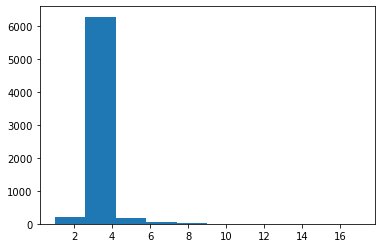

In [37]:
import matplotlib.pyplot as plt
plt.hist(values)
plt.show() 